## **Libraries Used**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dphi-official/Imbalanced_classes/blob/master/Dphi_demo_realtime.ipynb)

In [44]:
# to install these packages if they aren't there already, use below install commands:
# !pip install pandas
# !pip install numpy
# !pip install sklearn
# !pip install scipy
# !pip install imblearn
import pandas as pd
import numpy as np
import random
import sklearn
from collections import Counter

## How to Load Fraud Data

### 

In [45]:
df = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Imbalanced_classes/master/fraud_data.csv")

## Data Description :
IEEE Fraud Dataset was provided at Kaggle a year ago:
- **Categorical Features – Transaction**
- ProductCD – Product code
- card1 - card6 : payment card information, such as card type, card category, issue bank, country, etc.
- addr1, addr2
- P_emaildomain – Purchaser 
- R_emaildomain- Recipient
- M1 - M9 – Match between names on card and address etc.
- **Categorical Features - Identity**
- DeviceType
- DeviceInfo
- id_12 - id_38 customer identity variables
- The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).
- **Outcome/Target Variable – isFraud**
- whether transaction is fraud or not

#### More about this dataset here: https://www.kaggle.com/c/ieee-fraud-detection/data


## The target variable here is 'isFraud' whether the transaction is fraudulent. Let us look at how many fraud transactions are there and how many normal transactions are there in the dataset.

In [46]:
df.isFraud.value_counts()

0    57049
1     2005
Name: isFraud, dtype: int64

# Pre-Processing and Data Wrangling:

## Train Test Data Split - to evaluate performance in an unbiased manner

In [47]:
# set x and y variables
y = df['isFraud']
x= df.loc[:, df.columns != 'isFraud']


from sklearn.model_selection import train_test_split

# Split randomly into 70% train data and 30% test data
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3, random_state = 123) 


In [48]:
xTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41337 entries, 12662 to 52734
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(385), int64(17), object(31)
memory usage: 136.9+ MB


## Step 1. Check for missingness in variables 

In [49]:
xTrain.isnull().sum() #check how many missing/null values in each variable

TransactionID         0
TransactionDT         0
TransactionAmt        0
ProductCD             0
card1                 0
                  ...  
id_36             31403
id_37             31403
id_38             31403
DeviceType        31419
DeviceInfo        33011
Length: 433, dtype: int64

## Eliminate automatically variables with more than 20% of missingness

In [50]:
# Eliminate automatically variables with more than 20% of missingness

xTrain_before_filling= xTrain
xTrain = xTrain[xTrain.columns[xTrain.isnull().mean() < 0.2]]

## Let us see which among remaining columns have missing values in the code below

In [51]:
missing_cols=xTrain.columns[xTrain.isnull().mean() > 0]
print(missing_cols)

Index(['card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'P_emaildomain', 'D1', 'D10',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=162)


In [52]:
xTrain['card5'].isnull().mean() # let us use this variable for comparison later, keep this in mind for now!

0.007499334736434671

# Imputation : Filling missing values in a variable by reasonable approximations like mean of the variable to allow machine learning models to work

## Step 1a. Single Imputation Technique

## Impute Numeric Variables with mean of the variable

In [53]:
xTrain_single= xTrain
cols= xTrain_single.columns
num_cols = xTrain_single.select_dtypes(include=np.number).columns
xTrain_single.loc[:,num_cols]=xTrain_single.loc[:,num_cols].fillna(xTrain_single.loc[:,num_cols].mean())
print(num_cols)
print(xTrain_single.loc[:,num_cols].mean())

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2',
       'card3', 'card5', 'addr1', 'addr2', 'C1',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=177)
TransactionID     3.281805e+06
TransactionDT     7.357705e+06
TransactionAmt    1.347207e+02
card1             9.912457e+03
card2             3.626188e+02
                      ...     
V317              2.722976e+02
V318              1.823263e+02
V319              1.665254e+01
V320              4.211091e+01
V321              2.752951e+01
Length: 177, dtype: float64


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Impute Categorical Variables with mode of the variable

In [54]:
cat_cols= list(set(cols) - set(num_cols))
xTrain_single.loc[:,cat_cols] = xTrain_single.loc[:,cat_cols].fillna(xTrain.loc[:,cat_cols].mode().iloc[0])
train_cols = xTrain_single.columns
print(cat_cols)
print(xTrain_single.loc[:,cat_cols].mode().iloc[0])

['card4', 'P_emaildomain', 'ProductCD', 'card6']
card4                 visa
P_emaildomain    gmail.com
ProductCD                W
card6                debit
Name: 0, dtype: object


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Check if missingness is now 0 for all variables remaining 
##### empty column list indicates no variable has missing values anymore!

In [55]:
xTrain_single.columns[xTrain_single.isnull().mean() > 0] # select those variables with missing values

Index([], dtype='object')

### Comparing variable before and after filling: (remember variable 'Card5' earlier?)
Card5 variable before filling missing values with its mean

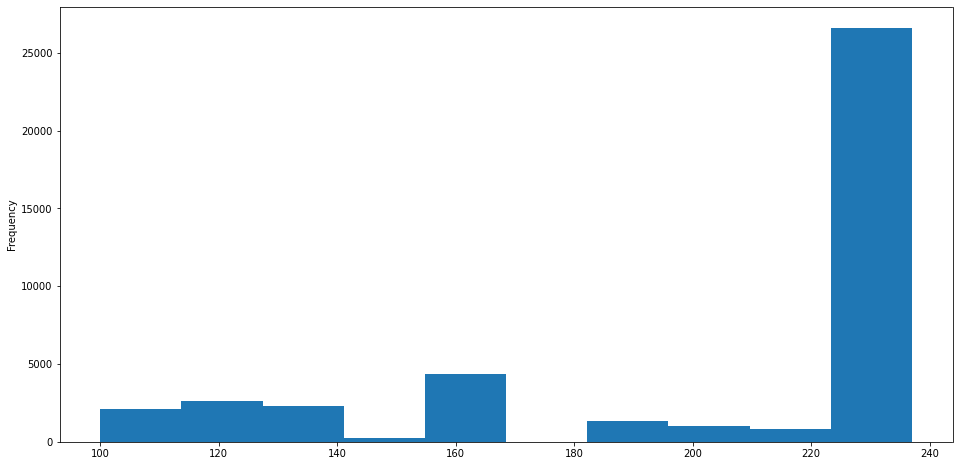

In [56]:
xTrain_single['card5'].plot.hist(figsize=(16,8));

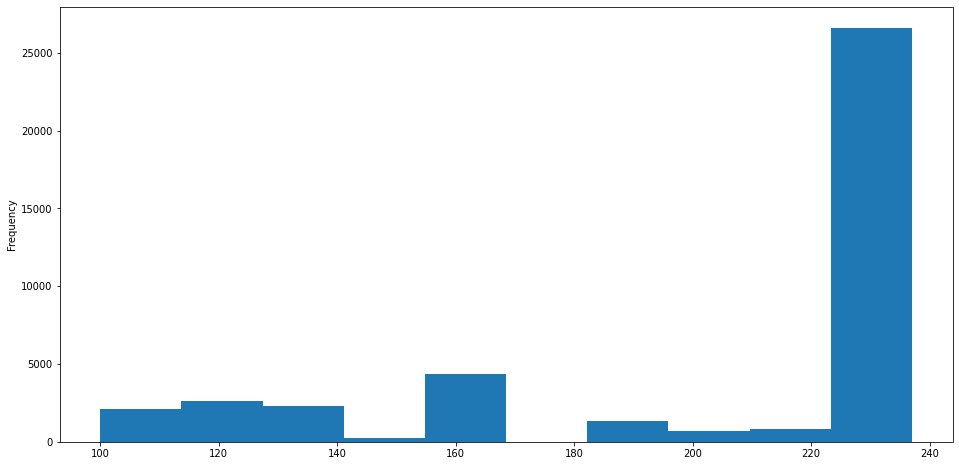

In [57]:
xTrain_before_filling['card5'].plot.hist(figsize=(16,8));

In [58]:
xTrain_single['card5'].describe()

count    41337.000000
mean       199.235991
std         41.036349
min        100.000000
25%        166.000000
50%        226.000000
75%        226.000000
max        237.000000
Name: card5, dtype: float64

In [59]:
xTrain_before_filling['card5'].describe()

count    41027.000000
mean       199.235991
std         41.191096
min        100.000000
25%        166.000000
50%        226.000000
75%        226.000000
max        237.000000
Name: card5, dtype: float64

### in above describe command, we are looking how is the variable distributed in terms of mean, standard deviation etc.

In [19]:
### The variable 'card5' didn't change much as a whole (except for very slight change in standard deviation of the variable) even after filling with mean values. So filling values isn't changing the existing variables much because of filling with measures like mean of the variable. It just models to not misunderstand missing values

In [60]:
xTrain= xTrain_single # let us single imputed data as further data for preprocessing in the next step

## Step 2. One hot encoding : To make all variables numeric to feed to machine learning process further

In [61]:
xTrain.info()
xTrain_dummy = pd.get_dummies(xTrain, prefix_sep='_', drop_first=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41337 entries, 12662 to 52734
Columns: 181 entries, TransactionID to V321
dtypes: float64(160), int64(17), object(4)
memory usage: 57.4+ MB


In [62]:
xTrain_dummy

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D10,D15,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,...,P_emaildomain_hotmail.com,P_emaildomain_hotmail.de,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_mac.com,P_emaildomain_mail.com,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_netzero.com,P_emaildomain_netzero.net,P_emaildomain_optonline.net,P_emaildomain_outlook.com,P_emaildomain_outlook.es,P_emaildomain_prodigy.net.mx,P_emaildomain_protonmail.com,P_emaildomain_ptd.net,P_emaildomain_q.com,P_emaildomain_roadrunner.com,P_emaildomain_rocketmail.com,P_emaildomain_sbcglobal.net,P_emaildomain_sc.rr.com,P_emaildomain_servicios-ta.com,P_emaildomain_suddenlink.net,P_emaildomain_twc.com,P_emaildomain_verizon.net,P_emaildomain_web.de,P_emaildomain_windstream.net,P_emaildomain_yahoo.co.jp,P_emaildomain_yahoo.co.uk,P_emaildomain_yahoo.com,P_emaildomain_yahoo.com.mx,P_emaildomain_yahoo.de,P_emaildomain_yahoo.es,P_emaildomain_yahoo.fr,P_emaildomain_ymail.com
12662,3058646,1612658,46.500,7861,494.0,150.0,226.0,299.000000,87.000000,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
47037,3469434,12533197,20.950,10748,455.0,150.0,195.0,337.000000,87.000000,9,10,0,0,6,9,0,0,6,0,10,0,49,8,136.0,82.000000,135.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29179,3302515,7855766,139.117,4606,141.0,185.0,137.0,290.763705,86.802851,1,1,0,1,0,1,1,0,0,0,1,1,0,0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40680,3010196,595984,280.330,4141,404.0,150.0,102.0,327.000000,87.000000,1,1,0,0,1,0,0,0,1,0,1,0,1,1,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6080,3288879,7447462,186.610,13266,321.0,150.0,226.0,158.000000,87.000000,13,11,0,0,7,5,0,0,7,0,7,0,24,9,1.0,40.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54370,3500688,13452492,311.950,10057,225.0,150.0,224.0,123.000000,87.000000,3,3,0,0,1,0,0,0,2,0,1,0,12,3,121.0,276.000000,276.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17730,3038837,1212291,114.950,2492,543.0,150.0,224.0,299.000000,87.000000,3,3,0,0,3,2,0,0,1,0,2,0,13,3,77.0,76.000000,76.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28030,3055357,1544901,75.000,1690,516.0,150.0,224.0,110.000000,87.000000,1,1,0,1,0,1,0,1,0,1,1,0,1,1,0.0,124.

## Finalizing the data before training a model

In [63]:
final_tr = pd.DataFrame(data=xTrain_dummy)

print(final_tr.head())
print(final_tr.shape)

       TransactionID  ...  P_emaildomain_ymail.com
12662        3058646  ...                        0
47037        3469434  ...                        0
29179        3302515  ...                        0
40680        3010196  ...                        0
6080         3288879  ...                        0

[5 rows x 245 columns]
(41337, 245)


In [64]:
## Decision Tree using grid search CV
from sklearn import tree
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4,cv=5,scoring = 'roc_auc')
clf.fit(X=final_tr, y=yTrain)
dt = clf.best_estimator_  #final decision tree!
print (clf.best_score_, clf.best_params_) 

0.7673556396758163 {'max_depth': 8}


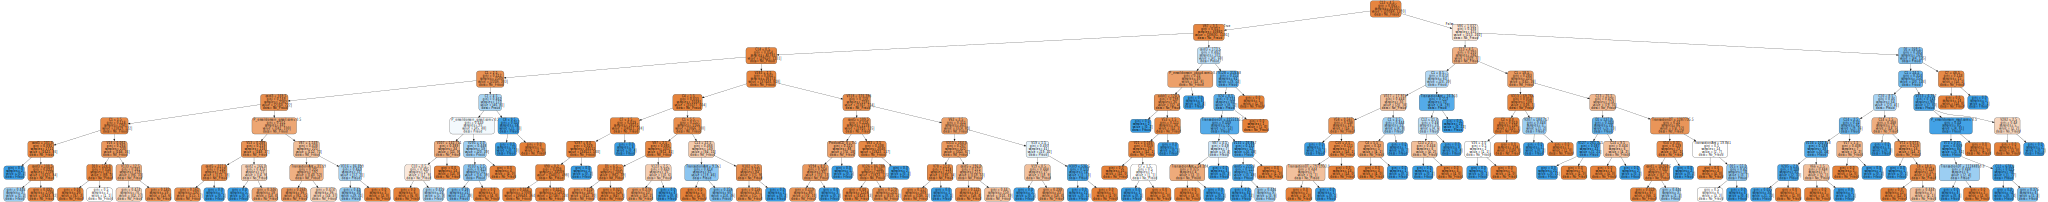

In [25]:
## Visualizing the decision tree initially- load visualization libraries
from sklearn.tree import export_graphviz
import graphviz
dot_data = tree.export_graphviz(dt, out_file=None, 
                    feature_names=final_tr.columns,  
                      class_names=['No_Fraud','Fraud'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

## Part 2: Handling Class Imbalance


### What is class imbalance?
Class imbalance in classification problem is too less data points of one class compared to another class we are trying to predict. It leads to machine to learn too much of the dominant class and too less about the minority class!




###  Let us use data from step 2 (one hot encoded), use SMOTE and resample data 

## SMOTE: Synthetic Minority Oversampling Technique

We can update the example to first oversample the minority class to have 20 percent the number of examples of the majority class (here about 8k), then use random undersampling to reduce the number of examples in the majority class. But we are NOT undersampling majority class as this worked best for this case and we will see the results later!


###  How to apply SMOTE oversampling and undersampling technique?

In [65]:
#Libraries and functions to load for class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


over = SMOTE(sampling_strategy=0.2,random_state=2) # 
under = RandomUnderSampler(sampling_strategy=0.2) #: we are avoid under sampling of non fraud data, to avoid removing data: this worked well in this case!
steps = [('o', over)] # only do oversampling
pipeline = Pipeline(steps=steps)
X_res, y_res = pipeline.fit_resample(xTrain_dummy, yTrain)


print('Original dataset shape %s' % Counter(yTrain))
print('Resampled dataset shape %s' % Counter(y_res))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape Counter({0: 39944, 1: 1393})
Resampled dataset shape Counter({0: 39944, 1: 7988})


### As you see in the above output, the dataset originally had just 1393 fraud cases and arodun 40k non fraud transactions.
### Now thanks to oversampling via SMOTE, we have  number of fraud and non-fraud cases in the ratio 1:5 and are relatively balanced information for model to learn

### Now let us use SMOTE'd data for training a decsision tree classifier on it!

In [66]:
from sklearn import preprocessing
#scaled_tr_res = preprocessing.StandardScaler().fit_transform(X_res)
final_tr_res = pd.DataFrame(data=X_res)
final_tr_res.columns= xTrain_dummy.columns
final_tr_res
print(final_tr_res.head())

   TransactionID  ...  P_emaildomain_ymail.com
0      3058646.0  ...                      0.0
1      3469434.0  ...                      0.0
2      3302515.0  ...                      0.0
3      3010196.0  ...                      0.0
4      3288879.0  ...                      0.0

[5 rows x 245 columns]


In [67]:
## Decision Tree using grid search CV
from sklearn import tree
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4,cv=5,scoring = 'roc_auc')
clf.fit(X=final_tr_res, y=y_res)
dt_smote = clf.best_estimator_  #final decision tree!
print (clf.best_score_, clf.best_params_) 

0.9250061999711088 {'max_depth': 7}


## As you see in best score for both models earlier, there is an increased performance on resampled data after handling class imbalance. But let us now judge early! Let us judge by the performance on the unseen test data which we separated earlier

## See the tree for yourself- tree with SMOTE'd data

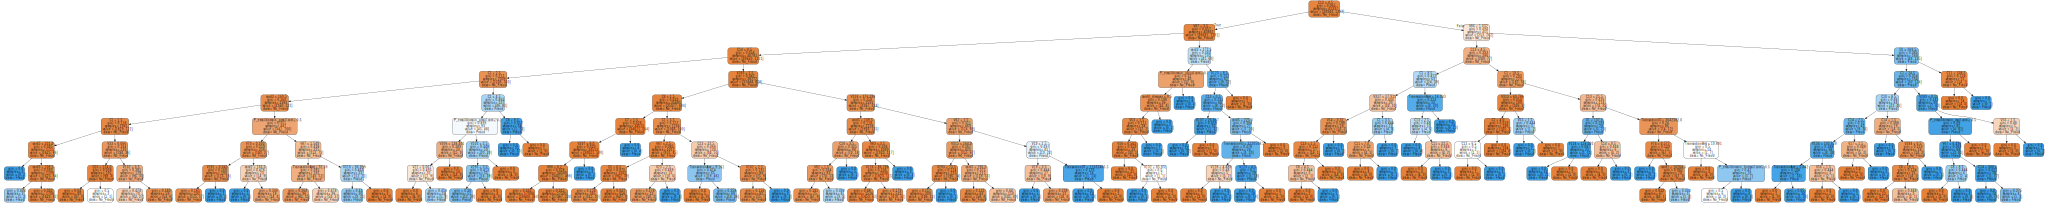

In [68]:
## Visualizing the decision tree initially- load visualization libraries
from sklearn.tree import export_graphviz
import graphviz
dot_data = tree.export_graphviz(dt, out_file=None, 
                    feature_names=final_tr.columns,  
                      class_names=['No_Fraud','Fraud'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

## The real test! 
## Apply on Test Data : apply steps 1-4 namely and then do prediction
1. Apply single imputation,
2. Select only variables which are used for training
3. One Hot encode variables
4: make sure test data again has exact same number of variables as training !

### Step 1: Account for missing values with single imputation like we did earlier

In [69]:

cols= xTest.columns
num_cols = xTest.select_dtypes(include=np.number).columns
xTest.loc[:,num_cols] = xTest.loc[:,num_cols].fillna(xTest.loc[:,num_cols].mean())

cat_cols= list(set(cols) - set(num_cols))
xTest.loc[:,cat_cols] = xTest.loc[:,cat_cols].fillna(xTest.loc[:,cat_cols].mode().iloc[0])
test_cols = xTest.columns


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Step 2:  Select only those features which are there in training #

In [70]:

#train_cols = xTrain.columns
xTest = xTest[train_cols] 

### Step 3. One Hot encode variables

In [71]:
xTest.info()
xTest_dummy = pd.get_dummies(xTest, prefix_sep='_', drop_first=True)
# Dummify categorical vars
xTest_dummy = pd.get_dummies(xTest, prefix_sep='__', drop_first=True)

##missing columns levels train and test
missing_levels_cols= list(set(xTrain_dummy.columns) - set(xTest_dummy.columns))


for c in missing_levels_cols:
    xTest_dummy[c]=0

# Select only those columns which are there in training data
xTest_dummy=xTest_dummy[xTrain_dummy.columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17717 entries, 59044 to 426
Columns: 181 entries, TransactionID to V321
dtypes: float64(160), int64(17), object(4)
memory usage: 24.6+ MB


### Step 4: make sure test data again has exact same number of variables as training !

In [72]:
from sklearn import preprocessing

final_ts = pd.DataFrame(data=xTest_dummy)
final_ts.columns= xTest_dummy.columns
final_ts
print(final_ts.head())
print(final_ts.shape)

       TransactionID  ...  P_emaildomain_ymail.com
59044        3195138  ...                        0
29992        3181635  ...                        0
56452        3246331  ...                        0
7059         3015519  ...                        0
49961        3353372  ...                        0

[5 rows x 245 columns]
(17717, 245)


### Prediction on test data: Without SMOTE vs With SMOTE

In [73]:
ytest_dt = dt.predict_proba(final_ts)



In [74]:
from sklearn.metrics import roc_curve,roc_auc_score
print('The ROC AUC score for 1st model without SMOTE is {}'.format(roc_auc_score(yTest,ytest_dt[:,1])))

The ROC AUC score for 1st model without SMOTE is 0.7712743569609466


In [75]:
ytest_dt_smote = dt_smote.predict_proba(final_ts)
print('The ROC AUC score for 1st model after SMOTE is {}'.format(roc_auc_score(yTest,ytest_dt_smote[:,1])))


The ROC AUC score for 1st model after SMOTE is 0.8195257855651272


## As you see, there is increase performance of decision tree classifer after SMOTE is applied, with respect to AUC. 

### Disclaimer: this is just for demo, there are various techniques one should consider before judging increase in performance. You will learn about them later!

# Additional Reading Material and to  try:

## Multivariate Imputation Example

### Multivariate Imputation : Imputation using values of other variables to predict the value of missing variable

In [76]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [89]:
df.isnull()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,False,False,...,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,True,False,False,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,...,False,False,True,True,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59049,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
59050,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
59051,False,False,False,False,False,False,False,False,False,

In [90]:
xTrain_multiple= df.copy()
imp = IterativeImputer(max_iter=100, random_state=0)

In [91]:
numeric_missing_cols = xTrain.columns[xTrain_multiple.isnull().mean() > 0]
numeric_missing_cols

IndexError: ignored

In [80]:

numeric_missing_cols= xTrain_multiple.loc[:,numeric_missing_cols].select_dtypes(include=np.number).columns
xTrain_multiple.loc[:,numeric_missing_cols]= imp.fit_transform(xTrain_multiple.loc[:,numeric_missing_cols].values)
print("The missing columns that are imputed are: " +numeric_missing_cols)
# the model learns that the second feature is double the first
#print(np.round(imp.transform(X_test)))

ValueError: ignored

##  Scaling/Normalizing Data

The preprocessing module further provides a utility class StandardScaler that implements the Transformer API to compute the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set.

In [ ]:
from sklearn import preprocessing
scaled_tr = preprocessing.StandardScaler().fit_transform(xTrain_dummy)
final_tr = pd.DataFrame(data=scaled_tr)
final_tr.columns= xTrain_dummy.columns
final_tr
print(final_tr.head())
print(final_tr.shape)